In [4]:
# in your notebook or another script
from Data_Cleaning import get_core_filtered
from Data_Enrichment import get_features

RAW_DIR = "data/raw"

# a) only filtered core DataFrames (Big-5) in memory
core = get_core_filtered(RAW_DIR)
df_teams_season       = core["df_teams_season"]
df_teams_details      = core["df_teams_details"]
df_players_profile    = core["df_players_profile"]
df_player_performance = core["df_player_performance"]

# b) features + Ballon d'Or flag in one line
df_feats, feature_cols = get_features(RAW_DIR)


/workspaces/Machine-learning/Data_Enrichment.py:232: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["ballon_dor_winner"] = df["ballon_dor_winner"].fillna(False).astype(bool)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
import textwrap


correlation analysis 

stationary test over performance variables 

In [10]:
safe_cols = [
    "goals","assists","penalty_goals","own_goals","yellow_cards","second_yellow_cards",
    "direct_red_cards","minutes_played","goals_conceded","clean_sheets","nb_on_pitch",
    "nb_in_group","subed_in","subed_out","height","matches_played","g_per90","a_per90",
    "ga_per90","pen_share","red_cards_total","discipline_rate","gc_per90","clean_sheet_rate",
    "ballon_dor_winner",
]
adf_results = []

for col in safe_cols:
    if col in df_feats.columns:
        # eliminar NA
        series = df_feats[col].dropna()
        if len(series) > 1:  # ADF necesita al menos 2 valores
            result = adfuller(series)
            adf_results.append({
                "variable": col,
                "adf_statistic": result[0],
                "p_value": result[1],
                "stationary": result[1] < 0.05
            })

adf_df = pd.DataFrame(adf_results)
print(adf_df)


               variable  adf_statistic       p_value  stationary
0                 goals     -44.408830  0.000000e+00        True
1               assists     -61.260303  0.000000e+00        True
2         penalty_goals     -45.730592  0.000000e+00        True
3             own_goals     -60.256633  0.000000e+00        True
4          yellow_cards     -58.536042  0.000000e+00        True
5   second_yellow_cards     -65.878946  0.000000e+00        True
6      direct_red_cards     -57.896241  0.000000e+00        True
7        minutes_played     -62.772513  0.000000e+00        True
8        goals_conceded     -49.608620  0.000000e+00        True
9          clean_sheets     -25.023504  0.000000e+00        True
10          nb_on_pitch     -30.623893  0.000000e+00        True
11          nb_in_group     -28.168585  0.000000e+00        True
12             subed_in     -58.497393  0.000000e+00        True
13            subed_out     -50.419666  0.000000e+00        True
14               height  

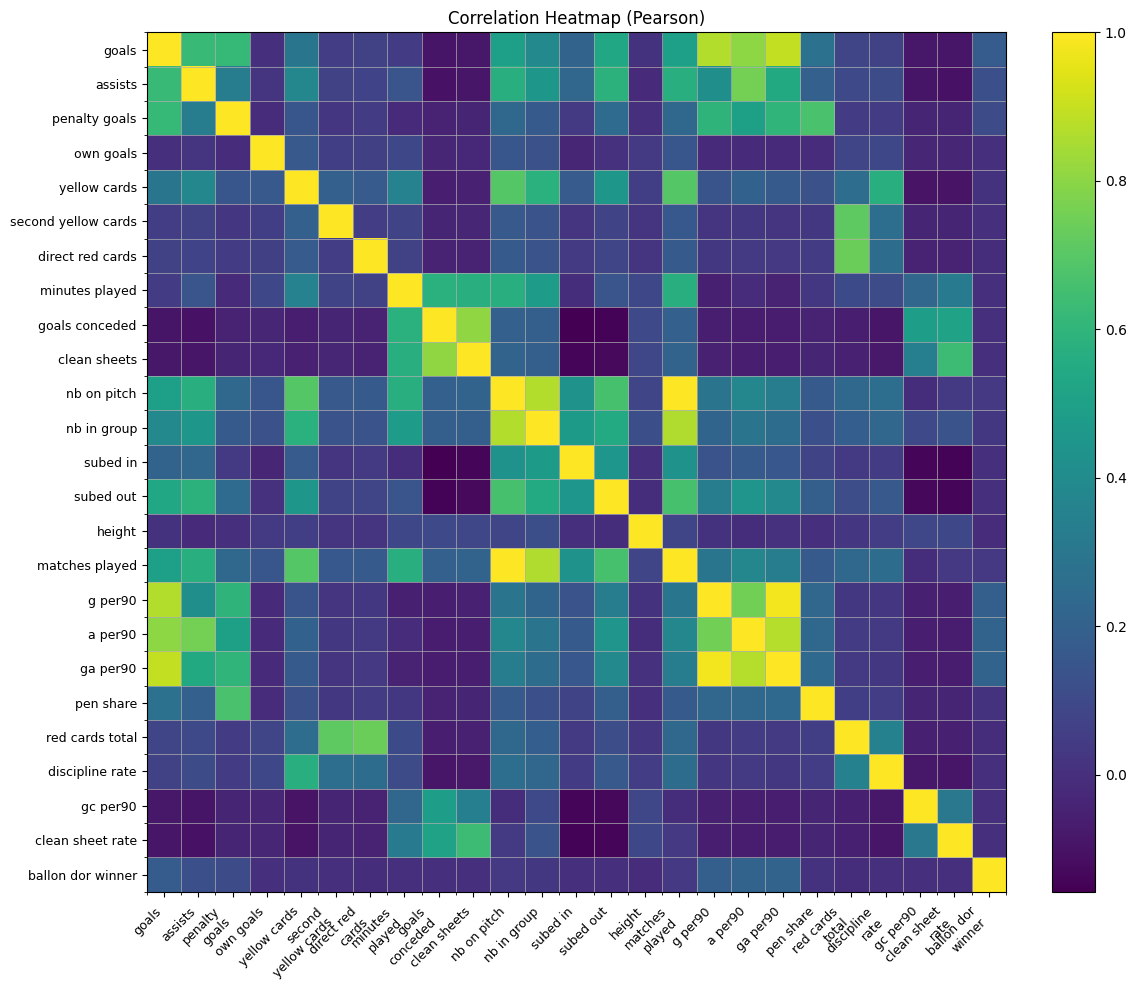

In [6]:
safe_cols = [
    "goals","assists","penalty_goals","own_goals","yellow_cards","second_yellow_cards",
    "direct_red_cards","minutes_played","goals_conceded","clean_sheets","nb_on_pitch",
    "nb_in_group","subed_in","subed_out","height","matches_played","g_per90","a_per90",
    "ga_per90","pen_share","red_cards_total","discipline_rate","gc_per90","clean_sheet_rate",
    "ballon_dor_winner",
]

X = df_feats[safe_cols].replace([np.inf, -np.inf], np.nan).dropna()
corr = X.corr(method="pearson")

# wrap labels to multiple lines (split underscores + wrap to width)
def wrap_label(s, width=12):
    s = s.replace("_", " ")
    return "\n".join(textwrap.wrap(s, width=width))

xlabels = [wrap_label(c, width=12) for c in corr.columns]
ylabels = [c.replace("_", " ") for c in corr.index]

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(corr.values, interpolation="nearest", aspect="equal")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation Heatmap (Pearson)")

n = len(corr.columns)
ticks = np.arange(n)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(xlabels, rotation=45, ha="right", va="top")
ax.set_yticklabels(ylabels)

# add light gridlines between cells
ax.set_xticks(np.arange(-0.5, n, 1), minor=True)
ax.set_yticks(np.arange(-0.5, n, 1), minor=True)
ax.grid(which="minor", linewidth=0.5)
ax.tick_params(axis="x", labelsize=9, pad=6)
ax.tick_params(axis="y", labelsize=9)

# give bottom extra space for the wrapped labels
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


Having the ingenierd features added, the only one that could be interest to tests are the deltas, z is just the standarization between leagues, lags just account past season and ¿delta is the diference so we may test stacionarity there?

In [21]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

def adf_test_deltas_with_flag(df, delta_cols, min_n=5, threshold=0.5):
    """
    Perform ADF test on delta columns per player.
    Adds a 'stationary' column: True if share_stationary > threshold.
    """
    out = {}
    gdf = df.sort_values("season_end_year").groupby("player_id")
    
    for col in delta_cols:
        pvals = []
        for pid, g in gdf:
            series = g[col].dropna()
            if len(series) >= min_n and series.nunique() > 1:
                try:
                    pvals.append(adfuller(series)[1])  # store p-value
                except Exception:
                    pass
        if pvals:
            out[col] = np.array(pvals)
    
    # Build summary
    rows = []
    for col, arr in out.items():
        share_stationary = (arr < 0.05).mean()  # proportion of players stationary
        rows.append({
            "metric": col,
            "n_players_tested": len(arr),
            "share_stationary": share_stationary,
            "stationary": share_stationary > threshold  # True if majority stationary
        })
    
    summary_df = pd.DataFrame(rows).sort_values("share_stationary", ascending=False).reset_index(drop=True)
    return summary_df


In [22]:
delta_cols = [
    "ga_per90_z_delta", "g_per90_z_delta", "a_per90_z_delta", "gc_per90_z_delta",
    "clean_sheet_rate_z_delta", "discipline_rate_z_delta", "pen_share_z_delta",
    "minutes_played_z_delta", "matches_played_z_delta"
]

delta_summary = adf_test_deltas_with_flag(df_feats, delta_cols)
print(delta_summary)


                     metric  n_players_tested  share_stationary  stationary
0           g_per90_z_delta              2284          0.564361        True
1    minutes_played_z_delta              2284          0.564361        True
2  clean_sheet_rate_z_delta              2284          0.549037        True
3   discipline_rate_z_delta              2284          0.543783        True
4           a_per90_z_delta              2284          0.534588        True
5          ga_per90_z_delta              2284          0.526708        True
6         pen_share_z_delta              2284          0.514448        True
7          gc_per90_z_delta              2284          0.506130        True
8    matches_played_z_delta              2284          0.432574       False


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_player_metric(df, player_id, metric, season_col='season_name', name_col='player_name'):
    """
    Plots a time series for a specific player and metric.
    Handles seasons in '22/23' string format and plots original, lag1, and delta series if available.
    Includes player name in the title if available.
    """
    df_player = df[df['player_id'] == player_id].copy()
    
    # Get player name (if column exists)
    player_name = df_player[name_col].iloc[0] if name_col in df_player.columns else str(player_id)
    
    # Ensure the season column is string
    df_player[season_col] = df_player[season_col].astype(str)
    
    # Convert season strings like '22/23' to numeric
    df_player['season_num'] = pd.to_numeric(
        df_player[season_col].str.split('/').str[0], errors='coerce'
    ) + 2000
    
    # Ensure metric is numeric
    df_player[metric] = pd.to_numeric(df_player[metric], errors='coerce')
    
    # Drop invalid rows
    df_player = df_player.dropna(subset=['season_num', metric])
    df_player = df_player.sort_values('season_num')

    plt.figure(figsize=(10,6))
    plt.plot(df_player['season_num'], df_player[metric], marker='o', linestyle='-', label='Original')

    # Plot lag1 if exists
    lag_col = f"{metric}_lag1"
    if lag_col in df_player.columns:
        df_player[lag_col] = pd.to_numeric(df_player[lag_col], errors='coerce')
        plt.plot(df_player['season_num'], df_player[lag_col], marker='x', linestyle='--', label='Lag1')

    # Plot delta if exists
    delta_col = f"{metric}_delta"
    if delta_col in df_player.columns:
        df_player[delta_col] = pd.to_numeric(df_player[delta_col], errors='coerce')
        plt.plot(df_player['season_num'], df_player[delta_col], marker='s', linestyle=':', label='Delta')

    plt.title(f"{metric} over time for {player_name} (ID: {player_id})")
    plt.xlabel("Season (start year)")
    plt.ylabel(metric)
    plt.xticks(df_player['season_num'].astype(int))  # force numeric ticks
    plt.grid(True)
    plt.legend()
    plt.show()


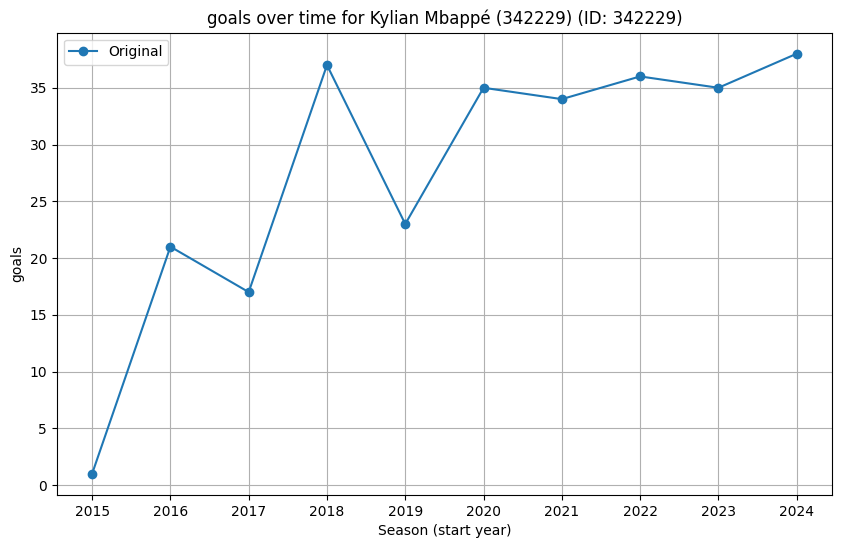

In [53]:
plot_player_metric(df_feats, player_id="342229", metric='goals')


In [9]:
df_num = df_feats.select_dtypes(include=[np.number]).drop(
    columns=['player_id', 'team_id'], errors='ignore'
)
# make sure everything is float so pandas can build the covariance matrix
df_num = df_num.astype(float)
# compute covariance matrix
M = df_num.cov()
# eigenvalues and eigenvectors
from numpy import linalg as LA
w, v = LA.eig(M)
w  # eigenvalues

array([5.97389797e+05, 4.30893210e+02, 3.89693513e+02, 4.85392768e+01,
       3.65855942e+01, 1.95107942e+01, 1.78878677e+01, 1.55443977e+01,
       1.02215194e+01, 4.31239651e+00, 3.60210766e+00, 3.00795139e+00,
       2.13500485e+00, 1.81367450e+00, 1.57646642e+00, 1.36982418e+00,
       1.29979790e+00, 1.17271993e+00, 1.15103795e+00, 1.10810894e+00,
       9.85391691e-01, 9.51748249e-01, 9.15878704e-01, 7.76642647e-01,
       6.53740303e-01, 4.83138503e-01, 4.72212477e-01, 4.00206485e-01,
       3.89064261e-01, 3.05904262e-01, 2.66990454e-01, 2.04573013e-01,
       1.40533244e-01, 1.10762155e-01, 1.02795140e-01, 7.32335306e-02,
       6.31499292e-02, 6.09397553e-02, 4.81673194e-02, 4.15125096e-02,
       3.70364272e-02, 3.17645162e-02, 2.96603721e-02, 2.46847472e-02,
       2.25388571e-02, 2.19033972e-02, 2.09741960e-02, 1.91937200e-02,
       1.21431694e-02, 9.63188975e-03, 8.96720958e-03, 6.38787494e-03,
       5.00178403e-03, 3.17096084e-03, 2.96579277e-03, 1.96921920e-03,
      

In [10]:
pca = PCA()
pca.fit(df_num)


,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


In [11]:
pca.components_

array([[ 2.03113964e-04,  4.37737109e-04, -1.62334725e-05, ...,
         5.56573227e-06,  8.70157597e-06,  3.92116140e-06],
       [ 6.72429421e-02,  4.33824809e-02,  6.59725515e-03, ...,
         2.11902971e-05,  2.85733986e-04,  1.47405842e-04],
       [-6.94404433e-02, -5.16481262e-02, -6.76386525e-03, ...,
        -4.81651328e-05, -3.49162059e-04, -1.80424727e-04],
       ...,
       [ 0.00000000e+00, -8.27361294e-11,  6.27880581e-12, ...,
         2.92407395e-10,  1.55249171e-11, -2.41652442e-10],
       [-0.00000000e+00,  8.34351195e-13,  2.86539735e-11, ...,
        -4.75013529e-11, -7.76903932e-13,  4.00217712e-11],
       [-0.00000000e+00, -2.56228116e-11, -8.00288237e-12, ...,
         9.78237407e-11,  5.72554179e-12, -7.19902852e-11]],
      shape=(66, 66))

In [12]:
pca.explained_variance_

array([5.97389797e+05, 4.30893210e+02, 3.89693513e+02, 4.85392768e+01,
       3.65855942e+01, 1.95107942e+01, 1.78878677e+01, 1.55443977e+01,
       1.02215194e+01, 4.31239651e+00, 3.60210766e+00, 3.00795139e+00,
       2.13500485e+00, 1.81367450e+00, 1.57646642e+00, 1.36982418e+00,
       1.29979790e+00, 1.17271993e+00, 1.15103795e+00, 1.10810894e+00,
       9.85391691e-01, 9.51748249e-01, 9.15878704e-01, 7.76642647e-01,
       6.53740303e-01, 4.83138503e-01, 4.72212477e-01, 4.00206485e-01,
       3.89064261e-01, 3.05904262e-01, 2.66990454e-01, 2.04573013e-01,
       1.40533244e-01, 1.10762155e-01, 1.02795140e-01, 7.32335306e-02,
       6.31499292e-02, 6.09397553e-02, 4.81673194e-02, 4.15125096e-02,
       3.70364272e-02, 3.17645162e-02, 2.96603721e-02, 2.46847472e-02,
       2.25388571e-02, 2.19033972e-02, 2.09741960e-02, 1.91937200e-02,
       1.21431694e-02, 9.63188975e-03, 8.96720958e-03, 6.38787494e-03,
       5.00178403e-03, 3.17096084e-03, 2.96579277e-03, 1.96921920e-03,
      

In [13]:
pp = pca.transform(df_num)
def biplot(score,coeff,pcax,pcay,labels=None, Labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1/(xs.max()- xs.min())
    scaley = 1/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(len(xs)): # Iterate through the number of samples
        if Labels is None:
            pass # Placeholder for empty if block
        else:
            plt.text(xs[i]*scalex, ys[i]*scaley, Labels[i], color='blue', ha='center', va='center')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

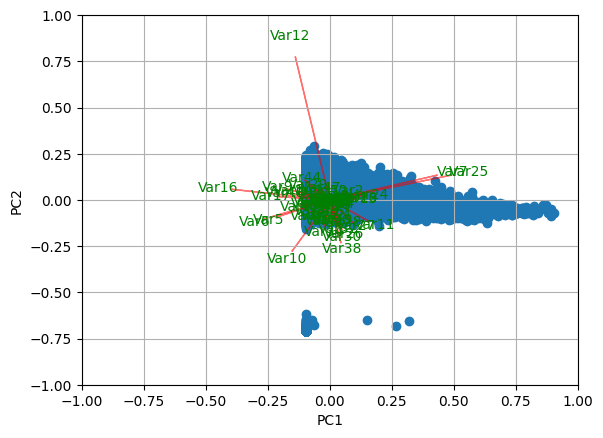

In [14]:
biplot(pp,pca.components_,1,2)
plt.show()

In [15]:
min_max_scaler = preprocessing.MinMaxScaler()
X1 = min_max_scaler.fit_transform(df_num)

In [16]:
pca = PCA()
X_pca=pca.fit(X1)

In [17]:
pca.components_

array([[ 4.76345212e-02,  8.77392042e-02,  2.03602285e-02, ...,
         4.08252322e-03,  8.63354462e-03,  7.25504165e-03],
       [-1.02887499e-01, -1.31968026e-01, -6.57930420e-02, ...,
         2.57449139e-02, -4.72505884e-03, -1.98766616e-02],
       [ 4.82037091e-02,  5.51695744e-02,  4.80501458e-02, ...,
        -3.41990620e-04, -1.00015115e-02,  1.93501955e-02],
       ...,
       [ 0.00000000e+00, -5.86948403e-14, -1.95254717e-13, ...,
         2.99322141e-13,  8.49996478e-14, -2.73746059e-13],
       [-0.00000000e+00, -2.83306296e-15, -2.11197780e-14, ...,
         8.92515228e-16,  6.88685220e-16, -3.33760797e-15],
       [-0.00000000e+00,  1.63300195e-15,  9.85185654e-16, ...,
         1.07457446e-14,  1.00058850e-14,  3.95516953e-15]],
      shape=(66, 66))

In [18]:
pca.explained_variance_

array([3.16638160e-01, 5.91205013e-02, 3.99322916e-02, 3.15901150e-02,
       2.76889677e-02, 2.37437964e-02, 1.80619144e-02, 1.60314110e-02,
       1.53166866e-02, 1.22790704e-02, 9.86482968e-03, 9.65541149e-03,
       9.30987955e-03, 8.52761305e-03, 8.46190230e-03, 6.88874874e-03,
       6.13982941e-03, 5.92845984e-03, 4.92814619e-03, 4.39172085e-03,
       4.02226538e-03, 3.06873538e-03, 2.65591999e-03, 2.19982826e-03,
       1.92369911e-03, 1.57823065e-03, 1.19603861e-03, 1.05660419e-03,
       1.00776815e-03, 7.98751530e-04, 7.72762932e-04, 6.62022652e-04,
       5.80061214e-04, 5.26699049e-04, 5.07081870e-04, 4.73764136e-04,
       4.50017879e-04, 4.30466373e-04, 3.37595711e-04, 2.55960298e-04,
       2.34000195e-04, 2.16351359e-04, 1.99720648e-04, 1.89227076e-04,
       1.73248290e-04, 1.51586148e-04, 1.12624389e-04, 9.11325960e-05,
       8.74428178e-05, 7.59776734e-05, 6.92826119e-05, 5.91541777e-05,
       5.40915338e-05, 4.81759274e-05, 4.41920238e-05, 2.72548952e-05,
      

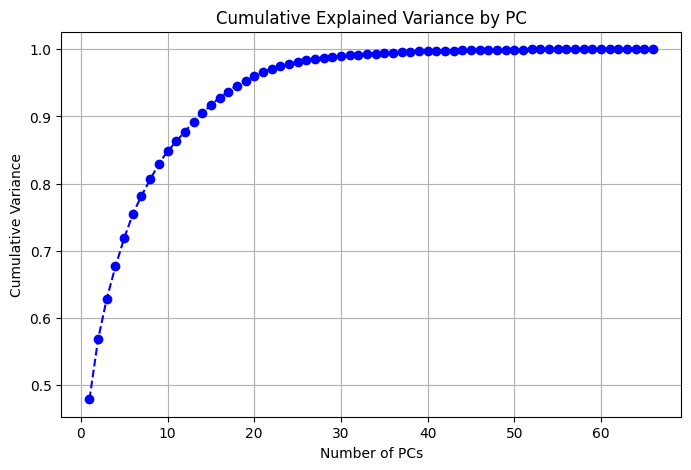

In [19]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# --- Visualize Explained variance ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by PC')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()


In [20]:
var_exp_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})
print(var_exp_df)

   Component  Explained Variance  Cumulative Variance
0        PC1        4.790891e-01             0.479089
1        PC2        8.945222e-02             0.568541
2        PC3        6.041952e-02             0.628961
3        PC4        4.779740e-02             0.676758
4        PC5        4.189477e-02             0.718653
..       ...                 ...                  ...
61      PC62        5.148402e-06             1.000000
62      PC63        1.513066e-07             1.000000
63      PC64        1.001598e-15             1.000000
64      PC65        3.511449e-18             1.000000
65      PC66        0.000000e+00             1.000000

[66 rows x 3 columns]


In [21]:
features = df_num # solo las variables
labels = df_feats["player_id"]  # abreviaturas de los estados

# Escalar los datos
X_scaled = StandardScaler().fit_transform(features)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Obtener vectores de las variables originales
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

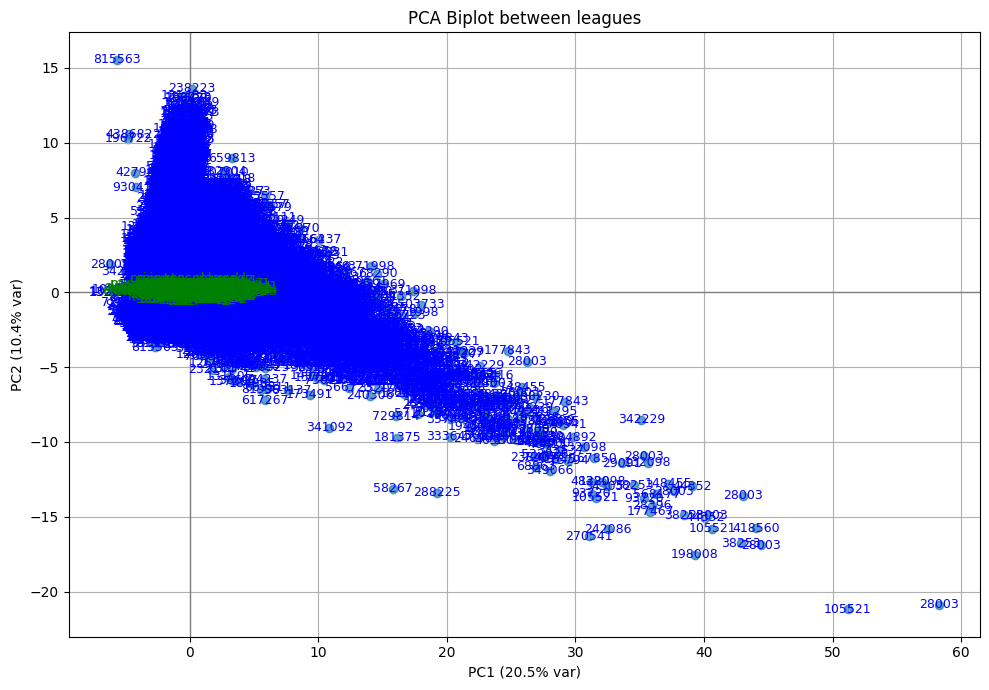

In [22]:
# Crear el biplot
plt.figure(figsize=(10, 7))

# 1. Puntos (proyecciones de los estados)
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

# 2. Etiquetas (abreviaturas de los estados)
for i, txt in enumerate(labels):
    plt.text(X_pca[i, 0], X_pca[i, 1], txt, fontsize=9, color='blue', ha='center', va='center')

# 3. Flechas de las variables originales
for i, var in enumerate(features.columns):
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1], color='brown', alpha=0.7, head_width=0.02)
    plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, var, color='green', ha='center', va='center', fontsize=10)

# 4. Ejes y título
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("PCA Biplot between leagues")
plt.grid(True)
plt.axhline(0, color='grey', lw=1)
plt.axvline(0, color='grey', lw=1)
plt.tight_layout()
plt.show()


 Linear model selection and regularization: LASSO Regression, a shrinkage method


In [23]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [24]:

X_train, X_test, y_train, y_test = train_test_split(df_num, df_num, test_size=0.3, random_state=42)

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.575e+02, tolerance: 4.059e+02
  model = cd_fast.enet_coordinate_descent(


,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [26]:
# Evaluate model performance on test set
y_pred = lasso.predict(X_test)
print(y_pred.mean()) #Mean Square Error over the test set

41.124714926600305


In [27]:
# Model Score
print("Model Score: ", lasso.score(X_test, y_test))

Model Score:  0.9003558755746337


In [28]:
# Lasso Coefficient
lasso.coef_

array([[3.39735611, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.21841461, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.57741267, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00907115,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(66, 66))

In [29]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

np.random.seed(30) #we fix the seed so we can reproduce the data any time

# Perform grid search with cross-validation
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5)
lasso_cv.fit(X_train, y_train)

# Print best parameter values and score
print("Best Parameters:", lasso_cv.best_params_)
print("Best Score:", lasso_cv.best_score_)

/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.783e+02, tolerance: 3.543e+02
  model = cd_fast.enet_coordinate_descent(
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+02, tolerance: 4.819e+01
  model = cd_fast.enet_coordinate_descent(
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Best Parameters: {'alpha': 0.001}
Best Score: 0.9999823544674259


/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+01, tolerance: 2.827e+00
  model = cd_fast.enet_coordinate_descent(


In [30]:
#Let's extract the best value of alpha
lasso_cv.best_params_.get('alpha')

0.001

In [31]:
#And re-evaluate the Lasso regression model with this alpha
lasso = Lasso(alpha=lasso_cv.best_params_.get('alpha'))
lasso.fit(X_train, y_train)
# Evaluate model performance on test set
y_pred = lasso.predict(X_test)
print(y_pred.mean()) #Mean Square Error over the test set

/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.096e+03, tolerance: 4.426e+02
  model = cd_fast.enet_coordinate_descent(
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e+02, tolerance: 6.039e+01
  model = cd_fast.enet_coordinate_descent(
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

41.1242752509173


/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+01, tolerance: 2.827e+00
  model = cd_fast.enet_coordinate_descent(


In [32]:
# Model Score
print("Model Score: ", lasso.score(X_test, y_test))

Model Score:  0.9999822645164318


In [33]:
# Lasso Coefficient
lasso.coef_

array([[3.49635611, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.31674986, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.6762136 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.06100401, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.10807115,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0837543 ]], shape=(66, 66))

factor analysis


In [34]:
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler

# Keep only numeric cols and drop IDs
X = (df_feats.select_dtypes(include=[np.number])
         .drop(columns=['player_id','team_id'], errors='ignore')
         .replace([np.inf, -np.inf], np.nan)
         .dropna(axis=0))

# Drop constant columns (variance = 0)
X = X.loc[:, X.nunique(dropna=True) > 1]

# Standardize (recommended)
Xz = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)


In [35]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

chi2, p = calculate_bartlett_sphericity(Xz)   # want p < 0.05
kmo_per_var, kmo_model = calculate_kmo(Xz)    # >0.6 OK, >0.7 good, >0.8 great
print(f"Bartlett p={p:.3e}, KMO={kmo_model:.3f}")


Bartlett p=nan, KMO=0.686


/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/factor_analyzer/factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
/workspaces/Machine-learning/.venv/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
